In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from sklearn.linear_model import Ridge
from sklearn import metrics

def load_all_csvs(path_pattern="CRWV_*.csv"):
    files = glob.glob(path_pattern)
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        df['day'] = file.split('_')[1]  # e.g., 2025-04-03
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

Plotting 146199 entries


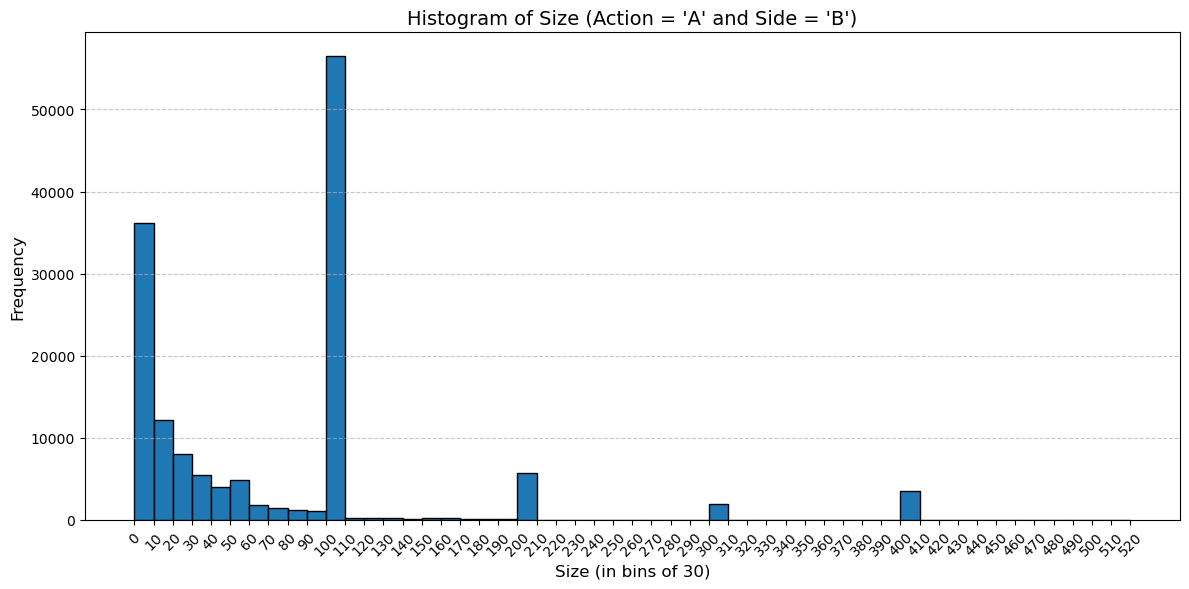

In [3]:
df = load_all_csvs(path_pattern="FROG_*.csv")

#Filter rows with action 'A' and side 'B'
filtered_df = df[(df['action'] == 'A') & (df['side'] == 'B')]

# Optionally remove outliers for clarity
filtered_df = filtered_df[filtered_df['size'] < 500]

# Define bin edges: from 0 to max size in steps of 30
max_size = filtered_df['size'].max()
bins = list(range(0, int(max_size) + 31, 10))

# Check how many values we're plotting
print(f"Plotting {len(filtered_df)} entries")

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['size'], bins=bins, color='#1f77b4', edgecolor='black')
plt.title("Histogram of Size (Action = 'A' and Side = 'B')", fontsize=14)
plt.xlabel("Size (in bins of 30)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Plotting 148336 entries


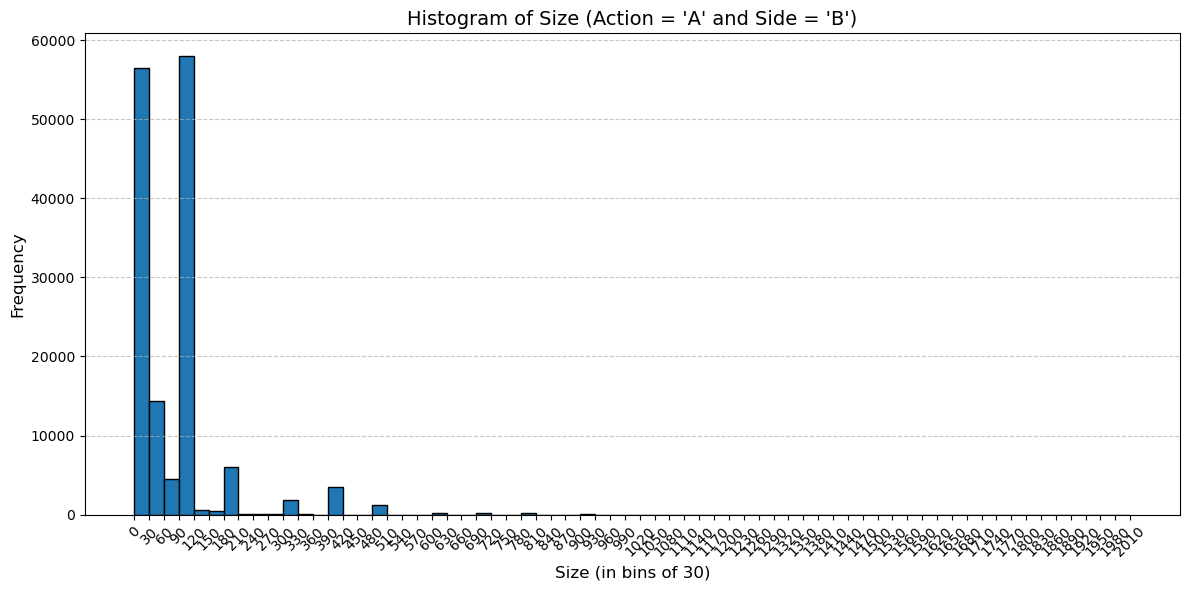

In [5]:
#Filter rows with action 'A' and side 'B'
filtered_df = df[(df['action'] == 'A') & (df['side'] == 'B')]

# Optionally remove outliers for clarity
filtered_df = filtered_df[filtered_df['size'] < 2000]

# Define bin edges: from 0 to max size in steps of 30
max_size = filtered_df['size'].max()
bins = list(range(0, int(max_size) + 31, 30))

# Check how many values we're plotting
print(f"Plotting {len(filtered_df)} entries")

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['size'], bins=bins, color='#1f77b4', edgecolor='black')
plt.title("Histogram of Size (Action = 'A' and Side = 'B')", fontsize=14)
plt.xlabel("Size (in bins of 30)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
def simulate_slippage_numpy(df, order_sizes):
    """
    Fast slippage calculator using NumPy, simulating buy-side market orders at given order sizes.
    Returns a long DataFrame with columns: ts_event, day, order_size, mid_price, vwap_price, slippage
    """
    df = df.copy()

    # Step 1: Compute mid-price
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2

    # Step 2: Prepare ask book levels
    ask_px = np.stack([df[f'ask_px_0{i}'].values for i in range(10)], axis=1)  # shape: (n_rows, 10)
    ask_sz = np.stack([df[f'ask_sz_0{i}'].values for i in range(10)], axis=1)

    n = len(df)
    records = []

    for size in order_sizes:
        vwap = np.full(n, np.nan)

        for i in range(n):
            needed = size
            cost = 0
            filled = 0

            for lvl in range(10):
                px = ask_px[i, lvl]
                sz = ask_sz[i, lvl]

                if np.isnan(px) or np.isnan(sz) or sz <= 0:
                    continue

                take = min(sz, needed)
                cost += take * px
                filled += take
                needed -= take

                if needed <= 0:
                    break

            if filled == size:
                vwap[i] = cost / filled  # Successful fill

        # Store results for this order size
        slippage = vwap - df['mid_price'].values
        records.append(pd.DataFrame({
            'ts_event': df['ts_event'].values,
            'day': df['day'].values,
            'order_size': size,
            'mid_price': df['mid_price'].values,
            'vwap_price': vwap,
            'slippage': slippage
        }))

    return pd.concat(records, ignore_index=True)

In [7]:
# Define the order sizes
sizes1 = list(range(5, 160, 10))    # 5, 15, ..., 155
sizes2 = list(range(205, 1006, 100))  # 205, 305, ..., 1005
order_sizes = sizes1 + sizes2

# Run the fast simulator
slippage_df = simulate_slippage_numpy(df, order_sizes)

# Optional: drop NaNs for unfilled orders
slippage_df = slippage_df.dropna(subset=['slippage'])

# Preview
slippage_df.head()


,ts_event,day,order_size,mid_price,vwap_price,slippage
0,2025-04-15 13:30:00.056321521+00:00,2025-04-15 00:00:00+00:00.csv,5,31.59,32.8,1.21
1,2025-04-15 13:30:00.056325948+00:00,2025-04-15 00:00:00+00:00.csv,5,31.59,32.8,1.21
2,2025-04-15 13:30:00.502291670+00:00,2025-04-15 00:00:00+00:00.csv,5,31.59,32.8,1.21
3,2025-04-15 13:30:00.623150905+00:00,2025-04-15 00:00:00+00:00.csv,5,31.59,32.8,1.21
4,2025-04-15 13:30:00.813789467+00:00,2025-04-15 00:00:00+00:00.csv,5,31.59,32.8,1.21


In [11]:
slippage_df['slippage_scaled'] = slippage_df['slippage'] * 100

def assign_minute_buckets(slippage_df):
    """Assigns a 'minute' column assuming each day has 390 minutes."""
    # First, count rows per day
    counts = slippage_df['day'].value_counts().to_dict()

    minute_list = []
    for day in slippage_df['day'].unique():
        num_rows = counts[day]
        minutes = np.tile(np.arange(390), int(np.ceil(num_rows / 390)))[:num_rows]
        minute_list.extend(minutes)
    
    slippage_df['minute'] = minute_list
    return slippage_df

def split_by_minute_stratified(slippage_df, test_frac=0.1, seed=42):
    """
    For each (minute, order_size), sample `test_frac` of rows into test set.
    """
    np.random.seed(seed)
    test_indices = []

    for minute in range(390):
        minute_df = slippage_df[slippage_df['minute'] == minute]
        for order_size in minute_df['order_size'].unique():
            group = minute_df[minute_df['order_size'] == order_size]
            test_idx = group.sample(frac=test_frac, random_state=seed).index.tolist()
            test_indices.extend(test_idx)

    slippage_df['set'] = 'train'
    slippage_df.loc[test_indices, 'set'] = 'test'
    
    return slippage_df


In [12]:
# Step 1: Assign minute labels (if not already done)
slippage_df = assign_minute_buckets(slippage_df)

# Step 2: Do stratified splitting
slippage_df = split_by_minute_stratified(slippage_df, test_frac=0.1)

# Step 3: Create final splits
train_df = slippage_df[slippage_df['set'] == 'train']
test_df  = slippage_df[slippage_df['set'] == 'test']


In [13]:
# Check that train/test ratios are consistent
print(train_df.shape[0], test_df.shape[0])
print(test_df.groupby(['minute', 'order_size']).size().head())


13101607 1455754
minute  order_size
0       5             151
        15            151
        25            151
        35            151
        45            151
dtype: int64


In [14]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def run_ridge_cv(train_df, test_df, alphas=[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]):
    """
    Runs Ridge Regression with built-in cross-validation over specified alpha values.
    Returns best model and evaluation metrics.
    """
    X_train = train_df[['minute', 'order_size']].values
    y_train = train_df['slippage'].values

    X_test = test_df[['minute', 'order_size']].values
    y_test = test_df['slippage'].values

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RidgeCV with 5-fold CV
    ridge_cv = RidgeCV(alphas=alphas, cv=5)
    ridge_cv.fit(X_train_scaled, y_train)

    # Best alpha
    best_alpha = ridge_cv.alpha_
    print(f"Best alpha from CV: {best_alpha}")

    # Evaluate on test set
    y_pred = ridge_cv.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.6f}")
    print(f"Test R²:  {r2:.6f}")
    return ridge_cv, scaler


In [15]:
model_cv, scaler = run_ridge_cv(train_df, test_df)

Best alpha from CV: 1000.0
Test MSE: 0.004971
Test R²:  0.089603


In [16]:
def compute_residuals(df, model, scaler):
    """
    Safely computes predicted slippage and residuals.
    Returns a new DataFrame with added 'predicted_slippage' and 'residual' columns.
    """
    df = df.copy()  # ensures you're not modifying a view

    X = df[['minute', 'order_size']].values
    X_scaled = scaler.transform(X)

    df.loc[:, 'predicted_slippage'] = model.predict(X_scaled)
    df.loc[:, 'residual'] = df['slippage'] - df['predicted_slippage']

    return df


In [17]:
train_df = compute_residuals(train_df, model_cv, scaler)
test_df  = compute_residuals(test_df, model_cv, scaler)


In [18]:
print(train_df)

                                     ts_event                            day  \
0         2025-04-15 13:30:00.056321521+00:00  2025-04-15 00:00:00+00:00.csv   
1         2025-04-15 13:30:00.056325948+00:00  2025-04-15 00:00:00+00:00.csv   
2         2025-04-15 13:30:00.502291670+00:00  2025-04-15 00:00:00+00:00.csv   
3         2025-04-15 13:30:00.623150905+00:00  2025-04-15 00:00:00+00:00.csv   
4         2025-04-15 13:30:00.813789467+00:00  2025-04-15 00:00:00+00:00.csv   
...                                       ...                            ...   
14725930  2025-04-29 19:59:41.626699601+00:00  2025-04-29 00:00:00+00:00.csv   
14725931  2025-04-29 19:59:41.626699601+00:00  2025-04-29 00:00:00+00:00.csv   
14725932  2025-04-29 19:59:41.626963978+00:00  2025-04-29 00:00:00+00:00.csv   
14725933  2025-04-29 19:59:41.626966591+00:00  2025-04-29 00:00:00+00:00.csv   
14725934  2025-04-29 19:59:42.064934016+00:00  2025-04-29 00:00:00+00:00.csv   

          order_size  mid_price  vwap_p

In [19]:
print(test_df)

                                     ts_event                            day  \
5850      2025-04-15 16:06:49.003539953+00:00  2025-04-15 00:00:00+00:00.csv   
5851      2025-04-15 16:06:54.829885298+00:00  2025-04-15 00:00:00+00:00.csv   
5852      2025-04-15 16:06:56.170006704+00:00  2025-04-15 00:00:00+00:00.csv   
5853      2025-04-15 16:06:58.949443650+00:00  2025-04-15 00:00:00+00:00.csv   
5854      2025-04-15 16:06:58.949537140+00:00  2025-04-15 00:00:00+00:00.csv   
...                                       ...                            ...   
14726320  2025-04-29 19:59:59.823762923+00:00  2025-04-29 00:00:00+00:00.csv   
14726321  2025-04-29 19:59:59.901588495+00:00  2025-04-29 00:00:00+00:00.csv   
14726322  2025-04-29 19:59:59.954342855+00:00  2025-04-29 00:00:00+00:00.csv   
14726323  2025-04-29 19:59:59.972995578+00:00  2025-04-29 00:00:00+00:00.csv   
14726324  2025-04-29 19:59:59.973002342+00:00  2025-04-29 00:00:00+00:00.csv   

          order_size  mid_price  vwap_p

In [20]:
def reshape_residuals(train_df):
    """
    Returns a dictionary: order_size -> time series of residuals (1D array of length 390 × n_days)
    """
    residual_series = {}

    for order_size in sorted(train_df['order_size'].unique()):
        df_subset = train_df[train_df['order_size'] == order_size]
        df_subset = df_subset.sort_values(by=['day', 'minute'])  # ensure time order
        residual_series[order_size] = df_subset['residual'].values

    return residual_series


In [21]:
def plot_fft_spectrum_fixed(residual_series, order_size):
    """
    Plots FFT power spectrum for a given order_size.
    Frequencies are converted from cycles/minute → cycles/day manually.
    """
    signal = residual_series[order_size]
    N = len(signal)

    # FFT
    fft_vals = np.fft.fft(signal)
    fft_power = np.abs(fft_vals[:N//2])**2

    # Frequencies in cycles per minute
    freqs_raw = np.fft.fftfreq(N, d=1)[:N//2]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(freqs_raw, fft_power)
    plt.title(f"FFT Power Spectrum of Residuals — Order Size {order_size}")
    plt.xlabel("Frequency (cycles per day)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return freqs_raw, fft_power


In [22]:
def get_top_k_frequencies(freqs, power, k=5):
    """
    Returns top-k frequency components by power
    """
    idx = np.argsort(power)[-k:][::-1]  # indices of top-k power
    return freqs[idx], power[idx]


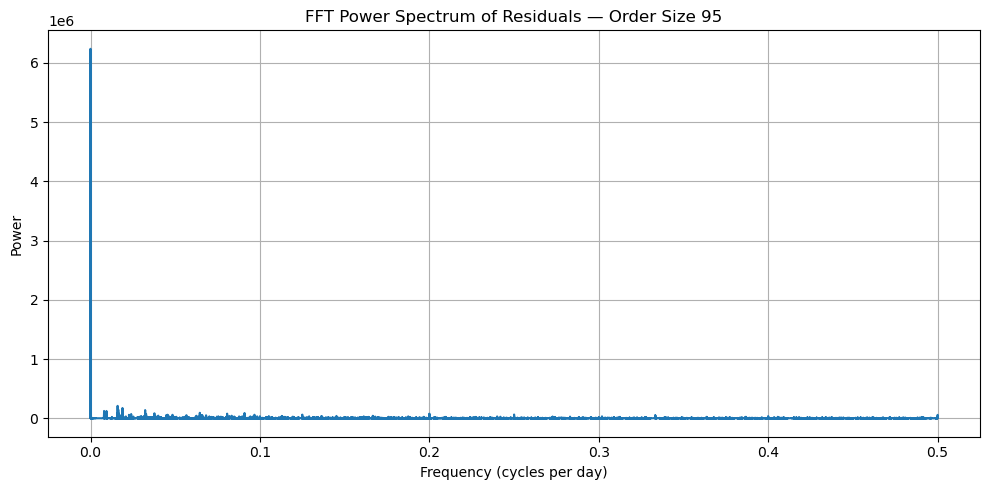

Top Frequencies (cycles/min): [1.88621591e-06 7.54486365e-06 1.50897273e-05 1.32035114e-05
 5.65864773e-06]
Power: [6236294.75942843 3093413.81715879 1622561.37320824 1507307.91981811
 1417895.50125421]


In [23]:
residual_series = reshape_residuals(train_df)

order_size = 95  # or any other
freqs, power = plot_fft_spectrum_fixed(residual_series, order_size)

top_freqs, top_power = get_top_k_frequencies(freqs, power)
print("Top Frequencies (cycles/min):", top_freqs)
print("Power:", top_power)


In [38]:
def reconstruct_from_top_k(signal, k=5):
    """
    Reconstructs a signal using only the top-k frequency components.
    Returns the smoothed signal and indices of retained frequencies.
    """
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    
    # Compute power spectrum
    power = np.abs(fft_vals)**2
    
    # Get indices of top-k components (excluding DC at 0)
    top_k_idx = np.argsort(power[1:N//2])[-k:] + 1  # skip DC
    full_idx = np.concatenate(([0], top_k_idx, -top_k_idx))  # include conjugates
    
    # Zero out everything else
    fft_filtered = np.zeros_like(fft_vals, dtype=complex)
    fft_filtered[full_idx] = fft_vals[full_idx]
    
    # Inverse FFT
    reconstructed = np.fft.ifft(fft_filtered).real
    
    return reconstructed, full_idx

In [40]:
def plot_reconstruction(original, reconstructed, order_size):
    plt.figure(figsize=(12, 5))
    plt.plot(original, label="Original Residual", alpha=0.6)
    plt.plot(reconstructed, label="Reconstructed (Top-k)", linewidth=2)
    plt.title(f"Residual Signal vs Reconstructed (Order Size {order_size})")
    plt.xlabel("Time Index (stacked minutes)")
    plt.ylabel("Slippage Residual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

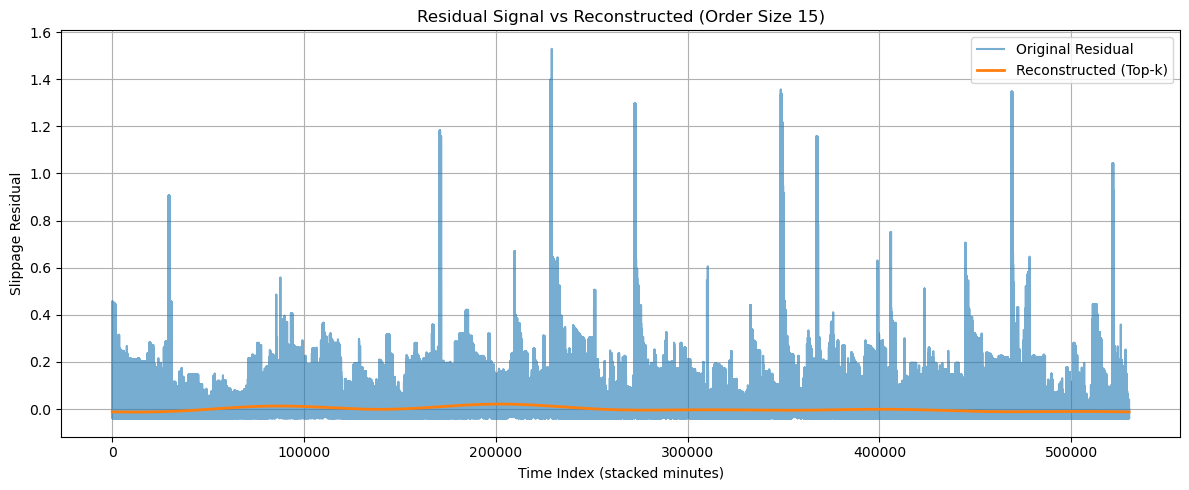

In [42]:
# Get signal
order_size = 15
signal = residual_series[order_size]

# Reconstruct using top 5 frequencies
reconstructed, _ = reconstruct_from_top_k(signal, k=5)

# Plot
plot_reconstruction(signal, reconstructed, order_size)


Degree 1: CV MSE = 0.0036, CV R² = 0.0113
Degree 2: CV MSE = 0.0036, CV R² = 0.0111
Degree 3: CV MSE = 0.0037, CV R² = 0.0017


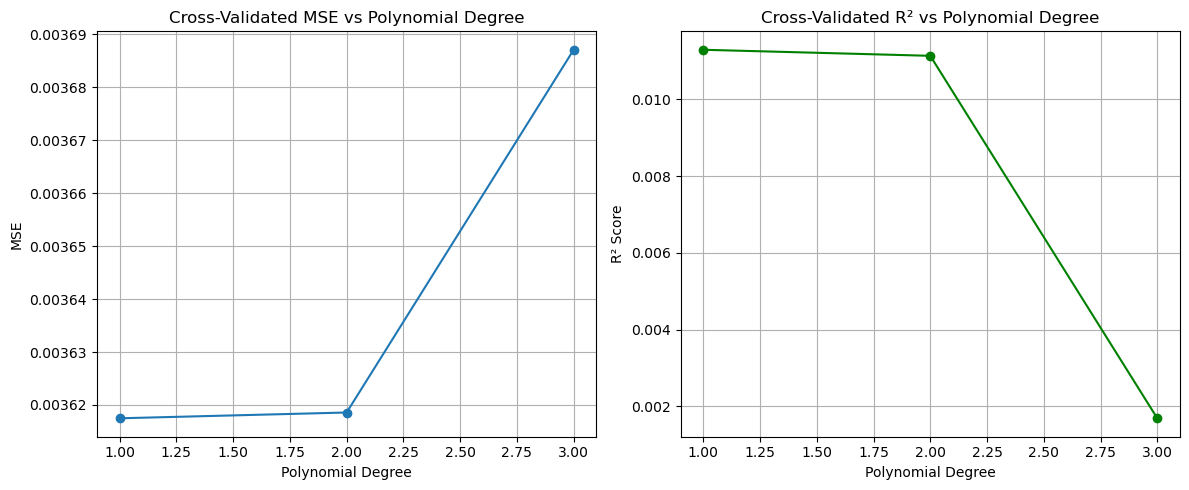

In [44]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# X = your features: minute_bucket and order_size
# y = your target: slippage_scaled


X_train = train_df[['minute', 'order_size']].values
y_train = train_df['slippage'].values

X_test = test_df[['minute', 'order_size']].values
y_test = test_df['slippage'].values

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

degrees = range(1, 4)
cv_mse_scores = []
cv_r2_scores = []

for deg in degrees:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=deg, include_bias=False),
        Ridge(alpha=1.0)  # You can tune alpha with GridSearchCV if needed
    )
    
    # Negative MSE (because sklearn returns negative for loss metrics)
    neg_mse = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

    mean_mse = -neg_mse.mean()
    mean_r2 = r2.mean()

    cv_mse_scores.append(mean_mse)
    cv_r2_scores.append(mean_r2)

    print(f"Degree {deg}: CV MSE = {mean_mse:.4f}, CV R² = {mean_r2:.4f}")

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, cv_mse_scores, marker='o')
plt.title('Cross-Validated MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(degrees, cv_r2_scores, marker='o', color='green')
plt.title('Cross-Validated R² vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

scores = cross_val_score(rf, X_train_scaled, y_train, cv=3, scoring='r2')
print("Mean CV R²:", scores.mean())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]:

Mean CV R²: -0.1029018916223503


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished
